# Middle East Countries Mapping

This notebook creates individual maps for Middle East countries (UAE, Saudi Arabia, Oman, Qatar, Bahrain, Kuwait) using matplotlib, cartopy, and geopandas.

Mapping 35 Middle East and Africa countries
Found existing shapefiles: ['ne_50m_admin_0_countries.shp']
Loading shapefile from: ne_50m_admin_0_countries.shp
Shapefile loaded successfully with 242 countries
Available columns: ['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN']...
Using 'NAME' column for country names


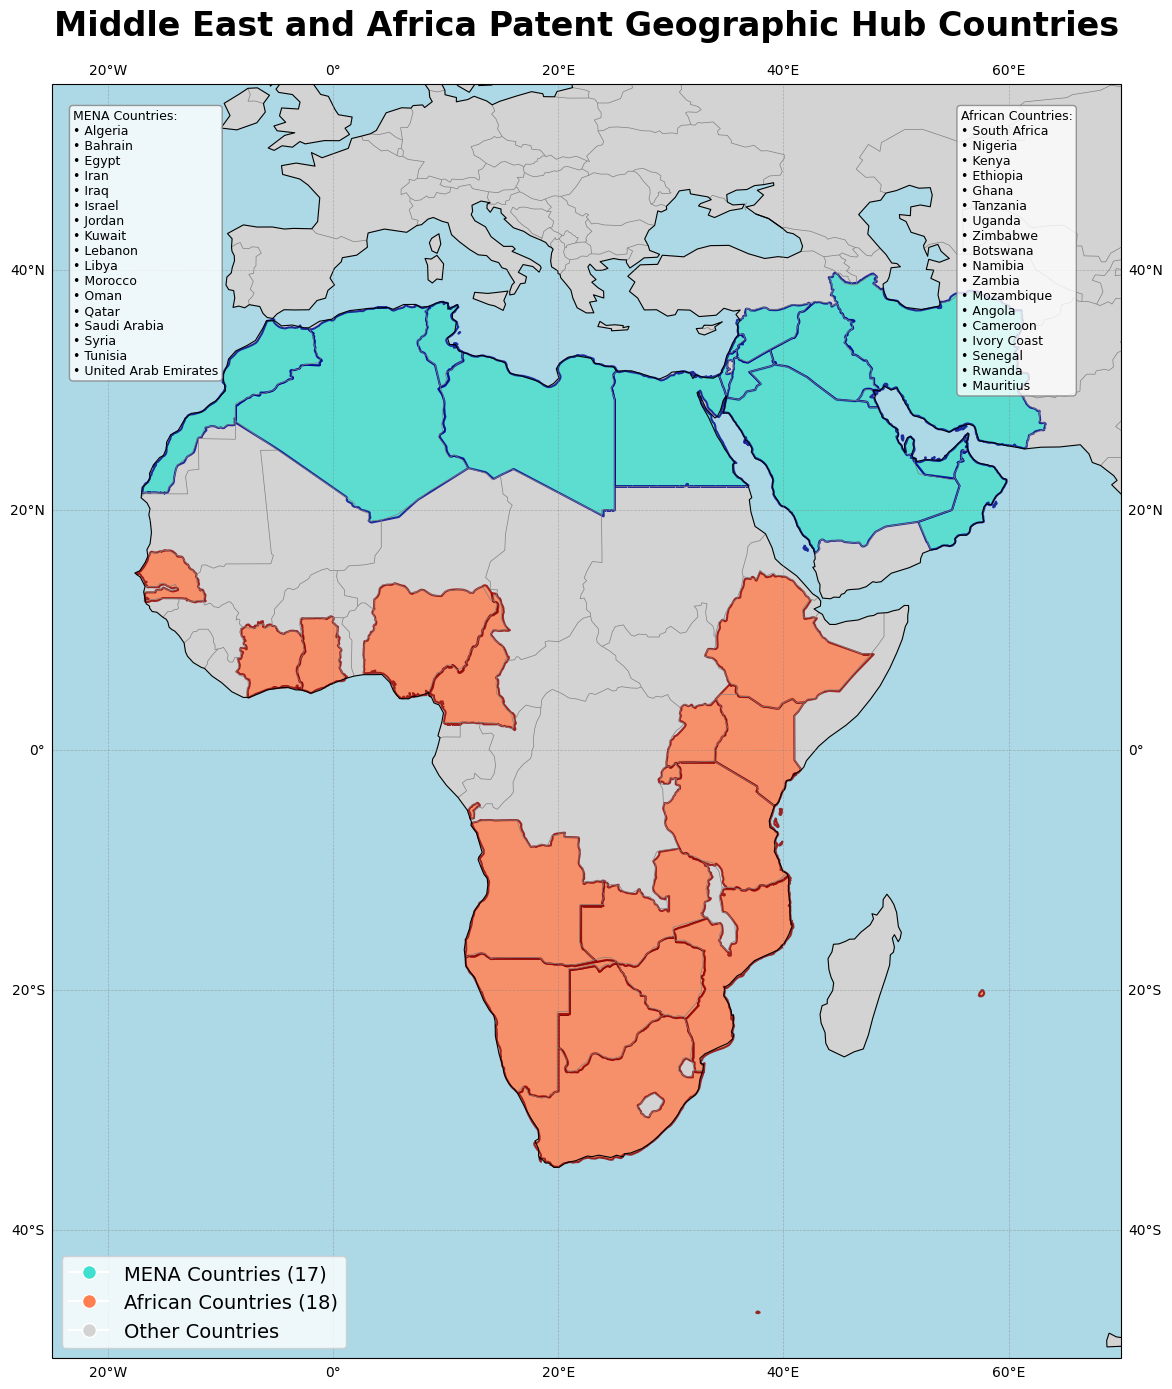


Summary:
Total MENA countries highlighted: 17
Total African countries highlighted: 18
Total countries mapped: 35

Highlighted MENA countries: ['Algeria', 'Bahrain', 'Egypt', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Libya', 'Morocco', 'Oman', 'Qatar', 'Saudi Arabia', 'Syria', 'Tunisia', 'United Arab Emirates']
Highlighted African countries: ['South Africa', 'Nigeria', 'Kenya', 'Ethiopia', 'Ghana', 'Tanzania', 'Uganda', 'Zimbabwe', 'Botswana', 'Namibia', 'Zambia', 'Mozambique', 'Angola', 'Cameroon', 'Ivory Coast', 'Senegal', 'Rwanda', 'Mauritius']


In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
from matplotlib.lines import Line2D
import os
import requests
import zipfile
import glob

# Define the Middle East and Africa Patent Hub countries
# MENA Countries
mena_countries = [
    'Algeria', 'Bahrain', 'Egypt', 'Iran', 'Iraq', 'Israel', 
    'Jordan', 'Kuwait', 'Lebanon', 'Libya', 'Morocco', 'Oman', 
    'Qatar', 'Saudi Arabia', 'Syria', 'Tunisia', 'United Arab Emirates'
]

# Major African countries typically included in MEA regions
african_countries = [
    'South Africa', 'Nigeria', 'Kenya', 'Ethiopia', 'Ghana', 'Tanzania',
    'Uganda', 'Zimbabwe', 'Botswana', 'Namibia', 'Zambia', 'Mozambique',
    'Angola', 'Cameroon', 'Ivory Coast', 'Senegal', 'Rwanda', 'Mauritius'
]

all_countries = mena_countries + african_countries
print(f"Mapping {len(all_countries)} Middle East and Africa countries")

# Check for existing shapefiles
shapefiles = glob.glob('**/*.shp', recursive=True)
if shapefiles:
    print(f"Found existing shapefiles: {shapefiles}")
    shapefile_path = shapefiles[0]
else:
    # Download Natural Earth data
    print("Downloading Natural Earth data...")
    url = 'https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip'
    
    # Download the file using wget
    os.system(f'wget -q -O ne_50m_admin_0_countries.zip "{url}"')
    
    # Extract the zip file
    os.system('unzip -q -o ne_50m_admin_0_countries.zip')
    
    # Find the shapefile
    shapefiles = glob.glob('**/*.shp', recursive=True)
    if shapefiles:
        shapefile_path = shapefiles[0]
        print(f"Extracted shapefile: {shapefile_path}")
    else:
        # If still not found, list all files to debug
        print("Could not find shapefile. Files in directory:")
        os.system('ls -la')
        raise FileNotFoundError("Shapefile not found after extraction")

# Load the shapefile
print(f"Loading shapefile from: {shapefile_path}")
gdf = gpd.read_file(shapefile_path)
print(f"Shapefile loaded successfully with {len(gdf)} countries")

# Check available columns
print(f"Available columns: {list(gdf.columns)[:10]}...")

# Find the name column
name_columns = ['NAME', 'ADMIN', 'NAME_EN', 'SOVEREIGNT']
name_column = None
for col in name_columns:
    if col in gdf.columns:
        name_column = col
        print(f"Using '{name_column}' column for country names")
        break

if not name_column:
    print("ERROR: Could not find suitable name column")
    print(f"All columns: {list(gdf.columns)}")
    raise ValueError("No suitable name column found")

# Create the map
fig = plt.figure(figsize=(20, 14))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Set extent to cover Middle East and Africa
ax.set_extent([-25, 70, -40, 45])

# Title
ax.set_title('Middle East and Africa Patent Geographic Hub Countries', 
             fontsize=24, fontweight='bold', pad=20)

# Add grid
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Country name mappings for variations
country_mappings = {
    'United Arab Emirates': ['United Arab Emirates', 'UAE'],
    'Iran': ['Iran', 'Iran (Islamic Republic of)'],
    'Syria': ['Syria', 'Syrian Arab Republic'],
    'Libya': ['Libya', 'Libyan Arab Jamahiriya'],
    'Ivory Coast': ['Ivory Coast', "Côte d'Ivoire", "Cote d'Ivoire"],
    'Tanzania': ['Tanzania', 'United Republic of Tanzania']
}

# Highlight countries with different colors for MENA vs Africa
highlighted_mena = []
highlighted_africa = []

for country in mena_countries:
    found = False
    # Try exact match
    country_shape = gdf[gdf[name_column] == country]
    
    # Try variations if not found
    if country_shape.empty and country in country_mappings:
        for variant in country_mappings[country]:
            country_shape = gdf[gdf[name_column] == variant]
            if not country_shape.empty:
                break
    
    # Try case-insensitive partial match as last resort
    if country_shape.empty:
        country_shape = gdf[gdf[name_column].str.contains(country, case=False, na=False)]
    
    if not country_shape.empty:
        country_shape.plot(ax=ax, facecolor='turquoise', edgecolor='darkblue', 
                          linewidth=1.5, alpha=0.8)
        highlighted_mena.append(country)

for country in african_countries:
    # Try exact match
    country_shape = gdf[gdf[name_column] == country]
    
    # Try variations if not found
    if country_shape.empty and country in country_mappings:
        for variant in country_mappings[country]:
            country_shape = gdf[gdf[name_column] == variant]
            if not country_shape.empty:
                break
    
    # Try case-insensitive partial match as last resort
    if country_shape.empty:
        country_shape = gdf[gdf[name_column].str.contains(country, case=False, na=False)]
    
    if not country_shape.empty:
        country_shape.plot(ax=ax, facecolor='coral', edgecolor='darkred', 
                          linewidth=1.5, alpha=0.8)
        highlighted_africa.append(country)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='turquoise', 
           markersize=10, label=f'MENA Countries ({len(highlighted_mena)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='coral', 
           markersize=10, label=f'African Countries ({len(highlighted_africa)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', 
           markersize=10, label='Other Countries')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=14)

# Add text boxes with ALL country lists - FIXED
# MENA countries box - showing ALL countries
mena_text = "MENA Countries:\n" + "\n".join(f"• {c}" for c in highlighted_mena)

props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
ax.text(0.02, 0.98, mena_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# African countries box - showing ALL countries
africa_text = "African Countries:\n" + "\n".join(f"• {c}" for c in highlighted_africa)

ax.text(0.85, 0.98, africa_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\nSummary:")
print(f"Total MENA countries highlighted: {len(highlighted_mena)}")
print(f"Total African countries highlighted: {len(highlighted_africa)}")
print(f"Total countries mapped: {len(highlighted_mena) + len(highlighted_africa)}")

# Show which countries couldn't be mapped
not_mapped_mena = [c for c in mena_countries if c not in highlighted_mena]
not_mapped_africa = [c for c in african_countries if c not in highlighted_africa]

if not_mapped_mena:
    print(f"\nMENA countries not found: {', '.join(not_mapped_mena)}")
if not_mapped_africa:
    print(f"African countries not found: {', '.join(not_mapped_africa)}")

# Print all highlighted countries for verification
print(f"\nHighlighted MENA countries: {highlighted_mena}")
print(f"Highlighted African countries: {highlighted_africa}")